In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.initializers import RandomUniform, Initializer, Constant

In [35]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras import backend as K
from keras.initializers import Initializer
from sklearn.cluster import KMeans

class InitCentersRandom(Initializer):
    def __init__(self, X):
        self.X = X

    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]
        idx = np.random.randint(self.X.shape[0], size=shape[0])
        return self.X[idx, :]


class RBFLayer(Layer):
    def __init__(self, units, gamma,initializer=None, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = gamma
        if not initializer:
            self.initializer = RandomUniform(0.0, 1.0)
        else:
            self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for the centers of the RBFs
        self.centers = self.add_weight(name='centers',
                                      shape=(self.units, input_shape[-1]),
                                      initializer='uniform',
                                      trainable=True)
        self.gamma = self.add_weight(name='gamma',
                                     shape=(self.units,),
                                     initializer=Constant(
                                         value=self.gamma),
                                     # initializer='ones',
                                     trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, x):

        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        return K.exp(-self.gamma * K.sum(H**2, axis=1))


        # C = self.centers[np.newaxis, :, :]
        # X = x[:, np.newaxis, :]

        # diffnorm = K.sum((C-X)**2, axis=-1)
        # ret = K.exp( - self.betas * diffnorm)
        # return ret

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.units


class InitCentersKMeans(Initializer):
    """ Initializer for initialization of centers of RBF network
        by clustering the given data set.
    # Arguments
        X: matrix, dataset
    """

    def __init__(self, X, n_clusters=20, max_iter=6000):
        self.X = X
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]

        n_centers = shape[0]
        km = KMeans(n_clusters=self.n_clusters, max_iter=self.max_iter, verbose=0)
        km.fit(self.X)
        return km.cluster_centers_    

In [36]:
# load Pivot data
url = 'https://raw.githubusercontent.com/ravsssh/HandballPrediction/main/Handball%20Prediction/data/P.csv'
df = pd.read_csv(url, delimiter=';')
# Menentukan input and output
X = df.drop(columns=["GOAL","7MSHOT","9MSHOT","6MSHOT","WINGSHOT","PIVOTSHOT","FASTBREAKSHOT"])
y = df.GOAL
# Membagi data set 80 : 20 train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Merancang Neural Network Model
model = Sequential()
model.add(Flatten(input_shape=(6,)))  
model.add(RBFLayer(20, 0.5))
model.add(Dense(1, activation='linear'))  
model.compile(optimizer='RMSprop', loss=mean_squared_error)  
# Melatih arsitektur model terhadap dataset
model.fit(X_train, y_train, batch_size=6, epochs=1000)
# Melakukan prediksi nilai
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

Epoch 1/1000
204/204 [==============================] - 1s 1ms/step - loss: 3.2972
Epoch 2/1000
204/204 [==============================] - 0s 1ms/step - loss: 1.8599
Epoch 3/1000
204/204 [==============================] - 0s 1ms/step - loss: 1.4429
Epoch 4/1000
204/204 [==============================] - 0s 1ms/step - loss: 1.3533
Epoch 5/1000
204/204 [==============================] - 0s 1ms/step - loss: 1.3411
Epoch 6/1000
204/204 [==============================] - 0s 978us/step - loss: 1.3329
Epoch 7/1000
204/204 [==============================] - 0s 1ms/step - loss: 1.3284
Epoch 8/1000
204/204 [==============================] - 0s 983us/step - loss: 1.3280
Epoch 9/1000
204/204 [==============================] - 0s 1ms/step - loss: 1.3235
Epoch 10/1000
204/204 [==============================] - 0s 1ms/step - loss: 1.3199
Epoch 11/1000
204/204 [==============================] - 0s 953us/step - loss: 1.3154
Epoch 12/1000
204/204 [==============================] - 0s 1ms/step - loss: 1.

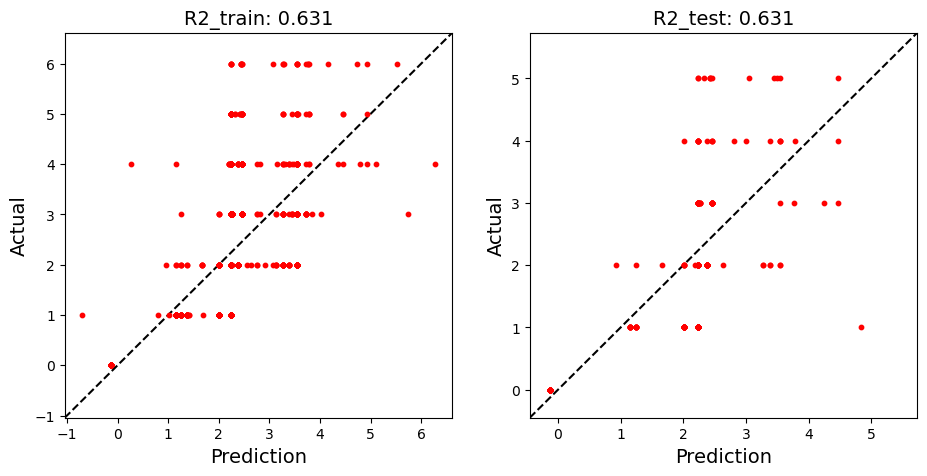

In [37]:
    # evaluation
    plt.figure(figsize=(11, 5))

    plt.subplot(121)
    plt.scatter(pred_train, y_train, c='r', s=10)
    x1, x2 = plt.xlim()
    y1, y2 = plt.ylim()
    lim = min(x1, y1), min(x2, y2)
    plt.xlim(*lim)
    plt.ylim(*lim)
    plt.plot(lim, lim, 'k--', zorder=-1)
    plt.xlabel("Prediction", fontsize=14)
    plt.ylabel("Actual", fontsize=14)
    plt.title(f"R2_train: {r2_score(y_train, pred_train):.3f}", fontsize=14)
    

    plt.subplot(122)
    plt.scatter(pred_test, y_test, c='r', s=10)
    x1, x2 = plt.xlim()
    y1, y2 = plt.ylim()
    lim = min(x1, y1), min(x2, y2)
    plt.xlim(*lim)
    plt.ylim(*lim)
    plt.plot(lim, lim, 'k--', zorder=-1)
    plt.xlabel("Prediction", fontsize=14)
    plt.ylabel("Actual", fontsize=14)
    plt.title(f"R2_test: {r2_score(y_test, pred_test):.3f}", fontsize=14)
    
    plt.show()
   


In [15]:
urlacc = 'https://raw.githubusercontent.com/ravsssh/HandballPrediction/main/Handball%20Prediction/data/Sensitivity/ACC.csv'
acc_df = pd.read_csv(urlacc, delimiter = ';')
acc_sensitivity = model.predict(acc_df)
print(acc_sensitivity)

3/3 [==============================] - 0s 1ms/step
[[-2.38078237e-02]
 [ 1.16143227e-02]
 [ 6.62784576e-02]
 [ 1.44675672e-01]
 [ 2.48763978e-01]
 [ 3.75971735e-01]
 [ 5.17767966e-01]
 [ 6.59653962e-01]
 [ 7.83128560e-01]
 [ 8.69473279e-01]
 [ 9.04361308e-01]
 [-2.38078237e-02]
 [ 3.29641700e-02]
 [ 1.15586698e-01]
 [ 2.27002084e-01]
 [ 3.65480244e-01]
 [ 5.22807658e-01]
 [ 6.83897316e-01]
 [ 8.28545868e-01]
 [ 9.35349286e-01]
 [ 9.86828625e-01]
 [ 9.74103034e-01]
 [-2.38078237e-02]
 [-2.23041177e-02]
 [-1.83290243e-02]
 [-1.25444531e-02]
 [-5.83332777e-03]
 [ 9.20116901e-04]
 [ 7.01302290e-03]
 [ 1.20233893e-02]
 [ 1.58143640e-02]
 [ 1.84690952e-02]
 [ 2.01963782e-02]
 [-2.38078237e-02]
 [-1.10026002e-02]
 [-7.97176361e-03]
 [-1.52439475e-02]
 [-3.15610170e-02]
 [-5.42339087e-02]
 [-7.98665881e-02]
 [-1.05181038e-01]
 [-1.27669871e-01]
 [-1.45913064e-01]
 [-1.59544766e-01]
 [-2.38078237e-02]
 [ 2.65657246e-01]
 [ 6.40994608e-01]
 [ 1.08797455e+00]
 [ 1.57166576e+00]
 [ 2.03825593e+00]

In [16]:
X

,7MACC,6MACC,9MACC,WINGACC,PIVOTACC,FASTBREAKACC
0,0.0,0.0,0,0.0,0.67,0.0
1,0.0,0.0,0,0.0,1.00,0.0
2,0.0,0.0,0,0.0,1.00,0.0
3,0.0,0.0,0,0.0,0.00,0.0
4,0.0,0.0,0,0.0,0.00,0.0
...,...,...,...,...,...,...
1521,0.0,0.0,0,0.0,0.00,0.0
1522,0.0,1.0,0,0.0,1.00,0.0
1523,0.0,0.0,0,0.0,1.00,0.0
1524,0.0,0.0,0,0.0,0.50,1.0


In [17]:
pd.DataFrame(acc_sensitivity).to_csv('sensitivitasaccuracy.csv', index=False)

In [38]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 6)                 0         
                                                                 
 rbf_layer_19 (RBFLayer)     (None, 20)                140       
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 161 (644.00 Byte)
Trainable params: 161 (644.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
